In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

#Load data

current_dir = os.path.abspath(".")
data_file_path = os.path.join(current_dir, "..", "data", "sample_data.csv")
data_df = pd.read_csv(data_file_path,index_col=0)
data_df.head()

,A,B,C,E,D,F,G
Date,,,,,,,
1970-01-01,0.034714,0.044682,0.123237,0.017675,0.047517,0.007915,0.226207
1970-02-01,0.024636,0.013480,0.110125,0.015751,0.007594,-0.015778,0.162066
1970-03-01,0.071551,0.023311,0.093957,0.045840,-0.041061,0.009084,0.088476
1970-04-01,-0.006951,0.040709,0.021486,0.038434,0.032244,0.018663,0.072146
1970-05-01,0.010011,0.038496,0.043715,0.024057,-0.017928,0.017422,0.053334


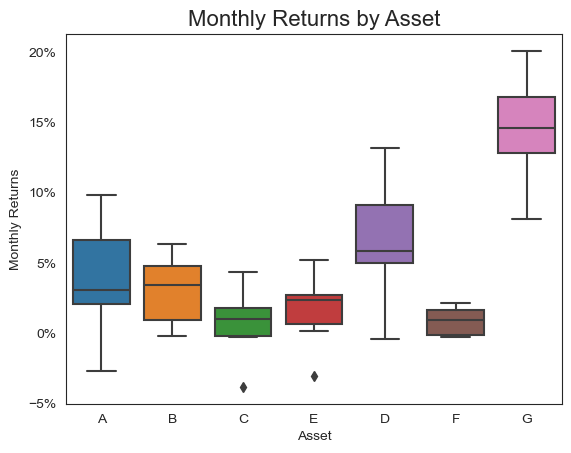

In [2]:
#box and whiskers

def box_plot_monthly_returns(data_df, start_date=None, end_date=None, title=None):
    data_df = data_df.reset_index()
    if start_date and end_date:
        mask = (data_df['Date'] >= start_date) & (data_df['Date'] <= end_date)
        data_df = data_df.loc[mask].reset_index(drop=True)
    
    data_melt_df = pd.melt(data_df, id_vars=['Date'])
    data_melt_df = data_melt_df.rename(columns={'variable': 'Asset', 'value': 'Monthly Returns'})
    
    sns.set_style("white")
    
    ax = sns.boxplot(x='Asset', y='Monthly Returns', data=data_melt_df)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

    if title:
        ax.set_title(title, fontsize=16)

    return plt


chart = box_plot_monthly_returns(data_df, start_date='2022-01-01', end_date='2022-06-30', title="Monthly Returns by Asset")
chart.show()

In [3]:
def summary_stats_table(data_df, start_date=None, end_date=None, title=None):
    if start_date and end_date:
        data_df = data_df.reset_index()
        mask = (data_df['Date'] >= start_date) & (data_df['Date'] <= end_date)
        data_df = data_df.loc[mask].reset_index(drop=True)
        data_df = data_df.set_index('Date')
    agg_stats = data_df.agg(['mean', 'std', 'median', 'min', 'max', 'skew', 'kurtosis'])
    
    # Capitalize first letters of index labels
    agg_stats = agg_stats.rename(index={'mean': 'Mean', 'median': 'Median', 'min': 'Min', 'max': 'Max', 'skew': 'Skew', 'kurtosis': 'Kurtosis'})
    # Change 'std' to 'Volatility'
    agg_stats = agg_stats.rename(index={'std': 'Volatility'})
    # Format numeric values
    decimals_rows = agg_stats.index.isin(['Skew', 'Kurtosis'])
    agg_stats[~decimals_rows] = agg_stats[~decimals_rows].applymap(lambda x: '{:.2f}%'.format(x*100))
    agg_stats[decimals_rows] = agg_stats[decimals_rows].applymap(lambda x: '{:.2f}'.format(x))
    
    return agg_stats

summary_stats_table(data_df, start_date='2022-01-01', end_date='2022-06-30')

,A,B,C,E,D,F,G
Mean,3.80%,3.03%,0.65%,1.61%,6.55%,0.85%,14.54%
Volatility,4.43%,2.60%,2.75%,2.80%,4.70%,1.07%,4.17%
Median,3.04%,3.39%,0.97%,2.32%,5.80%,0.90%,14.60%
Min,-2.69%,-0.23%,-3.85%,-3.05%,-0.47%,-0.26%,8.10%
Max,9.82%,6.33%,4.37%,5.19%,13.16%,2.12%,20.10%
Skew,-0.04,-0.11,-0.55,-0.77,-0.04,0.03,-0.35
Kurtosis,-0.24,-1.88,1.19,1.12,0.24,-2.78,0.10


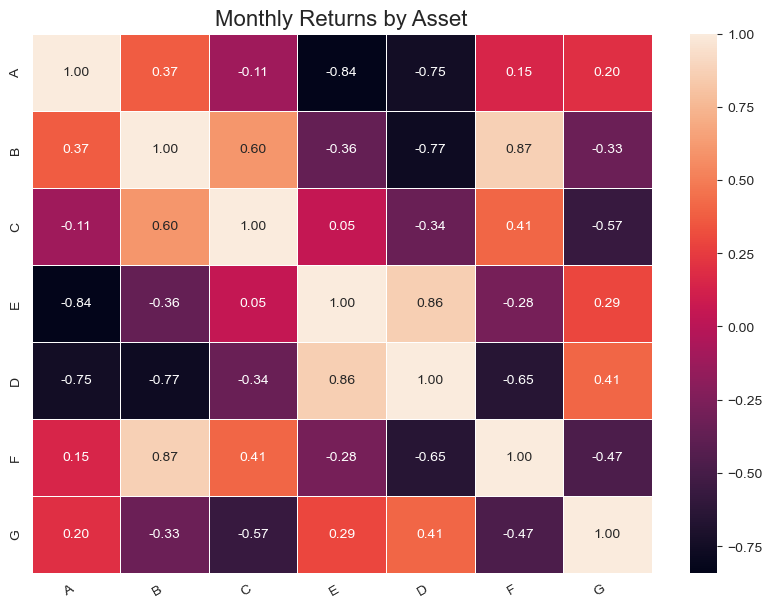

In [4]:
def plot_corr_matrix(data_df, start_date=None, end_date=None, title=None):
    if start_date and end_date:
        data_df = data_df.reset_index()
        mask = (data_df['Date'] >= start_date) & (data_df['Date'] <= end_date)
        data_df = data_df.loc[mask].reset_index(drop=True)
    corrmat = data_df.corr().round(2)
    plt.figure(figsize=(10, 7))
    sns.heatmap(corrmat, vmax=1, annot=True, fmt=".2f", linewidths=.5)
    plt.xticks(rotation=30, horizontalalignment='right')
    
    if title:
        plt.title(title, fontsize=16)
    
    return plt

corr_plot = plot_corr_matrix(data_df, start_date='2022-01-01', end_date='2022-06-30', title="Monthly Returns by Asset")
corr_plot.show()

In [5]:
# Portfolio randomizer function

def portfolio_randomizer(d_port, iterations=100000, seed=None):
    
    if seed:
        np.random.seed(seed)
    
    l_assets = d_port.keys()
    
    num_assets = len(l_assets)
    randomizer = np.random.dirichlet(np.ones(num_assets),size=iterations)
    df_ports = pd.DataFrame(randomizer)
    df_ports.columns = l_assets
    df_bound_ports = df_ports.copy()
    
    for i in l_assets:
        bound = d_port[i]
        lower = bound[0]
        upper = bound[1]
        df_bound_ports = df_bound_ports[(df_bound_ports[i] >= lower) & (df_bound_ports[i] <= upper)]
        
    df_bound_ports.reset_index(drop=True, inplace=True)
    
    return df_bound_ports


d_port = {'A': [0.0, 0.1], 'B': [0.15, 0.30], 'C': [0.0, 0.05], 'D': [0.15, 0.30], 'E': [0.10, 0.30], 'F': [0.10, 0.25], 'G': [0.0, 0.10]}

rand_port = portfolio_randomizer(d_port, seed=1234)
#rand_port.to_csv('sample_ports.csv')
rand_port

,A,B,C,D,E,F,G
0,0.031295,0.167439,0.033246,0.208434,0.273604,0.188958,0.097023
1,0.017565,0.163173,0.033850,0.260890,0.210619,0.247699,0.066204
2,0.060552,0.239061,0.047350,0.175124,0.231915,0.218387,0.027610
3,0.097910,0.199268,0.019483,0.241986,0.186144,0.202369,0.052840
4,0.020091,0.183606,0.015319,0.280308,0.286723,0.173007,0.040945
...,...,...,...,...,...,...,...
77,0.058217,0.295703,0.046770,0.199734,0.244186,0.135171,0.020218
78,0.085447,0.201059,0.022354,0.266676,0.211672,0.124542,0.088249
79,0.068588,0.283289,0.024159,0.202445,0.248110,0.103862,0.069548
80,0.059292,0.209134,0.041400,0.205949,0.243872,0.186661,0.053693


In [6]:
#generating ann return simulations

def time_series_to_annual(df_returns):
    
    grouped = df_returns.groupby(pd.Grouper(freq='A'))
    annual_dfs = {name: group for name, group in grouped}
    
    annual_ret_dfs = []

    for i in list(annual_dfs.keys()):
        annual_index = annual_dfs[i].copy()
        annual_index = annual_index.cumprod()
        ann_ret = annual_index.groupby(annual_index.index.year).tail(1)
        ann_ret = ann_ret - 1
        annual_ret_dfs.append(ann_ret)
        
    ann_rets_data = pd.concat(annual_ret_dfs)
        
    return ann_rets_data
    
def portfolio_returns(df_ports, total_returns):
    
    d_ports = df_ports.to_dict('index')
    dfs = []
    
    for key in d_ports:
        df = total_returns.copy()
        d_weight = d_ports[key]
        df['Portfolio Return'] = df.dot(pd.Series(d_weight))
        df = df[['Portfolio Return']]
        df = df + 1
        df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
        
        df_ann = time_series_to_annual(df)
        df_ann.reset_index(inplace=True)
        ##Insert split into annual returns
        dfs.append(df_ann)
        
    df_combined = pd.concat(dfs)
    df_combined.reset_index(inplace=True, drop=True)
        
    return df_combined

test_ret = portfolio_returns(rand_port, data_df)
test_ret

,Date,Portfolio Return
0,1970-12-01,0.595367
1,1971-12-01,0.738420
2,1972-12-01,0.582939
3,1973-12-01,0.427423
4,1974-12-01,0.603492
...,...,...
4423,2019-12-01,0.643620
4424,2020-12-01,0.566164
4425,2021-12-01,0.478195
4426,2022-12-01,0.525626
